In [2]:
%matplotlib inline
import pandas as pd
import pylab as p
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import median_absolute_error, mean_squared_error, explained_variance_score, mean_absolute_error, r2_score
from sklearn.cross_validation import ShuffleSplit, train_test_split
import scipy
import random
import time
from multiprocessing import Pool
from scipy.stats import boxcox
import matplotlib
import bayeslite as bl
matplotlib.style.use('ggplot')

In [3]:
core_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CORE.csv')
game_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/GAMES.csv')
player_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PLAYERS.csv', index_col=[0])
team_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/TEAM.csv', index_col=[0])
plays_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CORE.csv', index_col=[1])
pass_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PASS.csv', index_col=[0])
rush_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/RUSH.csv', index_col=[0])
pass_df = pass_df.join(plays_df)
rush_df = rush_df.join(plays_df)
conv_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/CONVS.csv', index_col=[0])
conv_df = conv_df.join(plays_df['GID'])
kickoff_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/KICKOFFS.csv', index_col=[0])
kickoff_df = kickoff_df.join(plays_df)

punt_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PUNTS.csv', index_col=[0])
punt_df = punt_df.join(plays_df)
tackle_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/TACKLES.csv', index_col=[0])
intercept_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/INTS.csv', index_col=[0])
fumble_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/FUMBLES.csv', index_col=[0])
tackle_df = tackle_df.join(plays_df)
intercept_df = intercept_df.join(plays_df)
fumble_df = fumble_df.join(plays_df)

In [4]:
#win_orig_df = win_orig_df.join(game_df)
offense_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/OFFENSE.csv', index_col=[2])
offense_df['PLAYER'] = offense_df.index
defense_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/DEFENSE.csv', index_col=[2])
defense_df['PLAYER'] = defense_df.index
players_df = pd.read_csv('/Users/jostheim/workspace/kaggle/data/nfl/NFLData_2000-2012/PLAYERS.csv', index_col=[0])
offense_df = offense_df.join(players_df['POS1'])
offense_df = offense_df.rename(columns={'POS1':'POS'})
offense_df.set_index('GID', inplace=True)
offense_df = offense_df.join(game_df['OU'])
offense_df = offense_df.join(game_df['SPRV'])
offense_df['GID'] = offense_df.index
offense_df.set_index('PLAYER', inplace=True)
offense_df['PLAYER'] = offense_df.index
defense_df = defense_df.join(players_df['POS1'])
defense_df = defense_df.rename(columns={'POS1':'POS'})

players_df['player_id'] = players_df.index
# offense_df = offense_df.join(players_df)
# defense_df = defense_df.join(players_df)

In [5]:
pass_groups = pass_df.groupby(['GID', 'PSR']) 
snp_list = []
for name, group in pass_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "PASSER_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

pass_groups = pass_df.groupby(['GID', 'TRG']) 
snp_list = []
for name, group in pass_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "TRG_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

rush_groups = rush_df.groupby(['GID', 'BC']) 
snp_list = []
for name, group in rush_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "BC_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
offense_df = pd.merge(offense_df, snp_df, how='left', on=['GID', 'PLAYER'])

fumble_groups = fumble_df.groupby(['GID', 'FRCV'])
fumble_list = []
for name, group in fumble_groups:
    fumble_list.append({"GID":name[0], "PLAYER":name[1], "FRCV":len(group)})
fumble_rcv_df = pd.DataFrame(fumble_list)
fumble_rcv_df = fumble_rcv_df.fillna(0)
offense_df = pd.merge(offense_df, fumble_rcv_df, how='left', on=['GID', 'PLAYER'])

run_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'BC'])
run_conv_list = []
for name, group in run_conv_groups:
    run_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_BC":len(group)})
run_conv_df = pd.DataFrame(run_conv_list)
run_conv_df = run_conv_df.fillna(0)
offense_df = pd.merge(offense_df, run_conv_df, how='left', on=['GID', 'PLAYER'])


passer_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'PSR'])
passer_conv_list = []
for name, group in passer_conv_groups:
    passer_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_PSR":len(group)})
passer_conv_df = pd.DataFrame(passer_conv_list)
passer_conv_df = passer_conv_df.fillna(0)
offense_df = pd.merge(offense_df, passer_conv_df, how='left', on=['GID', 'PLAYER'])

passertrg_conv_groups = conv_df[conv_df['CONV'] == 'Y'].groupby(['GID', 'TRG'])
passertrg_conv_list = []
for name, group in passertrg_conv_groups:
    passertrg_conv_list.append({"GID":name[0], "PLAYER":name[1], "2PTCONV_TRG":len(group)})
passertrg_conv_df = pd.DataFrame(passertrg_conv_list)
passertrg_conv_df = passertrg_conv_df.fillna(0)
offense_df = pd.merge(offense_df, passertrg_conv_df, how='left', on=['GID', 'PLAYER'])

punt_groups = punt_df[punt_df['PTSO'] == 6].groupby(['GID', 'PR'])
punt_list = []
for name, group in punt_groups:
    punt_list.append({"GID":name[0], "PLAYER":name[1], "PUNT_TDRET":len(group)})
punt_df = pd.DataFrame(punt_list)
punt_df = punt_df.fillna(0)
offense_df = pd.merge(offense_df, punt_df, how='left', on=['GID', 'PLAYER'])

kickoff_groups = kickoff_df[kickoff_df['PTSO'] == 6].groupby(['GID', 'KR'])
kickoff_list = []
for name, group in kickoff_groups:
    kickoff_list.append({"GID":name[0], "PLAYER":name[1], "KICKOFF_TDRET":len(group)})
kickoff_df = pd.DataFrame(kickoff_list)
kickoff_df = kickoff_df.fillna(0)
offense_df = pd.merge(offense_df, kickoff_df, how='left', on=['GID', 'PLAYER'])

offense_df['TDRET'] = offense_df['PUNT_TDRET'] + offense_df['KICKOFF_TDRET']

offense_df['2PTCONV'] = offense_df['2PTCONV_BC'] + offense_df['2PTCONV_PSR'] + offense_df['2PTCONV_TRG']

offense_df['SNP'] = offense_df['BC_SNP'] + offense_df['TRG_SNP'] +offense_df['PASSER_SNP']



In [6]:
tackle_groups = tackle_df.groupby(['GID', 'TCK']) 
snp_list = []
for name, group in tackle_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "TACKLE_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

intercept_groups = intercept_df.groupby(['GID', 'INT']) 
snp_list = []
for name, group in intercept_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "INTERCEPT_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

fumble_groups = fumble_df.groupby(['GID', 'FRCV']) 
snp_list = []
for name, group in fumble_groups:
    snp_list.append({"GID":name[0], "PLAYER":name[1], "FUMBLE_SNP":len(group)})
snp_df = pd.DataFrame(snp_list)
snp_df = snp_df.fillna(0)
defense_df = pd.merge(defense_df, snp_df, how='left', on=['GID', 'PLAYER'])

defense_df['SNP'] = defense_df['TACKLE_SNP'] + defense_df['INTERCEPT_SNP'] + defense_df['FUMBLE_SNP']

In [7]:
def draft_kings_score(row):
    score = (row['TDP']*4.0) + (row['PY']*0.04) + (3 * (1.0 if row['PY'] > 300 else 0.0)) 
    score += (-1*row['INT']) + (0.1*row['RY']) + (6.0*row['TDR']) 
    score += (3*(1.0 if row['RY'] > 100 else 0.0)) + (0.1 * row['RECY']) + (1 * row['REC']) + (6 * row['TDRE'])
    score += (3 *(1.0 if row['RECY'] > 100 else 0.0))
#     score += (6 * row['TDRET']) + (-1 * row['FUML']) + (6 * row['FRCV']) + (2 * row['2PTCONV']) 
    return score

offense_df['GID_tmp'] = offense_df['GID']
offense_df['TEAM_tmp'] = offense_df['TEAM']
offense_df = offense_df.set_index(['GID', 'TEAM'])
offense_df['GID'] = offense_df['GID_tmp']
offense_df['TEAM'] = offense_df['TEAM_tmp']

offense_df = offense_df.fillna(0.0)

offense_df['dk_fpts'] = offense_df.apply(lambda row:  draft_kings_score(row), axis=1)


defense_df['GID_tmp'] = defense_df['GID']
defense_df['TEAM_tmp'] = defense_df['TEAM']
defense_df = defense_df.set_index(['GID', 'TEAM'])
defense_df['GID'] = defense_df['GID_tmp']
defense_df['TEAM'] = defense_df['TEAM_tmp']

del offense_df['TEAM_tmp']
del offense_df['GID_tmp']
del defense_df['TEAM_tmp']
del defense_df['GID_tmp']

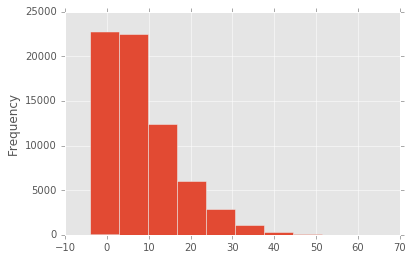

In [8]:
offense_df['dk_fpts'].plot(kind="hist")


In [9]:
player_id_map = {}
for i, player_id in enumerate(player_df.index):
    player_id_map[player_id] = i
print player_id_map

{'CL-1700': 1194, 'JG-3400': 2910, 'BP-1100': 733, 'JH-1800': 2940, 'EP-0400': 2220, 'RA-0900': 5055, 'FW-0200': 2325, 'MP-2100': 4523, 'BD-0700': 531, 'SW-1500': 5855, 'DD-0450': 1573, 'AP-1800': 308, 'JB-8400': 2713, 'AP-0400': 294, 'KH-0500': 3658, 'LG-0800': 3967, 'JM-3400': 3160, 'AJ-1500': 219, 'CS-3100': 1343, 'KH-2900': 3682, 'JB-5400': 2680, 'TF-1325': 6011, 'MG-2000': 4291, 'MM-2700': 4452, 'JH-0600': 2926, 'MB-1200': 4150, 'JS-2000': 3344, 'AH-1600': 178, 'GC-0900': 2361, 'DP-2300': 1900, 'AH-0800': 170, 'JG-2200': 2895, 'FV-0100': 2323, 'MS-5500': 4616, 'BB-2560': 471, 'WM-0550': 6447, 'GS-0100': 2446, 'CB-1160': 888, 'XO-0100': 6501, 'SE-0100': 5618, 'OB-0250': 4825, 'JP-2800': 3259, 'TA-0300': 5871, 'WH-1100': 6431, 'MP-1100': 4513, 'JC-0500': 2722, 'FS-0300': 2316, 'JC-3700': 2756, 'CD-1200': 1001, 'ME-0500': 4252, 'DC-1700': 1534, 'AJ-0100': 201, 'SR-0600': 5777, 'JC-2250': 2740, 'TJ-2900': 6105, 'DB-4100': 1491, 'KW-1100': 3874, 'TW-2100': 6306, 'CS-0100': 1311, 'DS-36

In [10]:
ignore_columns = ['PLAYER', 'GID', 'TID', 'TNAME', 'POS', 'UID', 'TEAM']
categorical_to_binary_columns = ['V', 'H','STAD', 'WDIR', 'COND', 'SURF', 'TEAM', 'DAY']
convert_to_float_columns = ['HUMD', 'WSPD']
non_aggregable_colums = ['SEAS', 'YEAR', 'GAME']


In [11]:
def get_game_features(index, game, my_team):
    feature = {}
    #setup the features from the game data (weather, point spread and stuff)
    if my_team == game['V'].values[0]:
        feature['is_visitor'] = 1.0
    else:
        feature['is_visitor'] = 0.0
    
    for key, val in game.iteritems():
        if key in ignore_columns:
            continue
        if key in categorical_to_binary_columns:
            if val.values[0] != "\N":
                feature['IS_{0}_{1}'.format(index, val.values[0])] = 1.0
        else:
            if str(val.dtype) == "object":
                if key in convert_to_float_columns:
                    if str.isdigit(val.values[0].strip()):
                        feature['{0}_{1}'.format(index, key)] = float(val.values[0])
                    else:
                        feature['{0}_{1}'.format(index, key)]  = 0.0
                else:
                    feature['{0}_{1}'.format(index, key)] = val.values[0]
            else:
                feature['{0}_{1}'.format(index, key)] = val.values[0]
    return feature

def get_team_game_features(index, team_game_data, game, players_team):
    feature = {}
    for team_game_row in team_game_data.iterrows():
        this_player_team = False
        # setup which team for this game is this_players team
        if players_team == team_game_row[1]['TNAME']:
            this_player_team = True
        if not this_player_team:
            continue
        # setup the features from the teams participating in the game
        for key, val in team_game_row[1].iteritems():
            if key in ignore_columns:
                continue
            if key in categorical_to_binary_columns:
                feature['IS_{0}_{1}_{2}'.format(index, val.values[0], 'my' if this_player_team else 'opp')] = 1.0
            else:
                feature['{0}_{1}_{2}'.format(index, 'my' if this_player_team else 'opp', key)] = val
    return feature

In [12]:
def get_features_for_player(index, offesne_player_row):
    feature = {}
    for key, val in offesne_player_row.iteritems():
        if key in ignore_columns:
            continue
        if key in categorical_to_binary_columns:
            feature["IS_{0}_{1}".format(val, index)] = 1.0
        else:
            feature["{0}_{1}".format(key, index)] = val
    return feature

In [13]:
def get_career_features_for_player(stats_df, player_id, game_id):
    feature = {}
    all_player = stats_df[(stats_df['PLAYER'] == player_id) & (stats_df['GID'] < game_id)]
#     all_player = stats_df[(stats_df['PLAYER'] == player_id)]
    for i, column in enumerate(all_player.columns):
        col_name = all_player.columns[i]
        if col_name in ignore_columns or str(all_player.dtypes[i]) == "object":
            continue
        feature["career_{0}_sum".format(col_name)] = all_player[column].sum()
        feature["career_{0}_mean".format(col_name)] = all_player[column].mean()
        feature["career_{0}_std".format(col_name)] = all_player[column].std()
    return feature

In [14]:
def get_moving_mean_features(index, moving_mean):
    feature = {}
    for i, col_name in enumerate(moving_mean.columns):
        if col_name in ignore_columns:
            continue
        if col_name not in categorical_to_binary_columns:
            feature["moving_average_{0}_{1}_sum".format(index, col_name)] = moving_mean[col_name].sum()
            feature["moving_average_{0}_{1}_mean".format(index, col_name)] = moving_mean[col_name].mean()
            feature["moving_average_{0}_{1}_std".format(index, col_name)] = moving_mean[col_name].std()
    return feature

In [15]:
def get_previous_game_features(index, game_id, team):
    feature = {}
    games = game_df[game_df['GID'] < game_id]
    games = games.sort(['GID'], ascending=[0])
    games['winner'] = games.apply(lambda: 1.0 if (games['V'] == team and games['PTSV'] > games['PTSH']) or (games['H'] == team and games['PTSH'] > games['PTSV']) else 0.0) 

def get_current_game_features(index, game_id):
    feature = {}
    game = game_df[game_df['GID'] == game_id]
    feature['OU'] = game['OU'].values[0]
    feature['SPRV'] = game['SPRV'].values[0]
    feature['WEEK'] = game['WEEK'].values[0]
    feature['SEAS'] = game['SEAS'].values[0]
    return feature

    

In [16]:
def get_okay_cols(df, ignore_categorical=True): 
    okay_cols = ['dk_fpts']
#     for col in df.columns:
#         if (col not in ignore_columns and col not in non_aggregable_colums and (not ignore_categorical or col not in categorical_to_binary_columns)):
#             okay_cols.append(col)
    return okay_cols+[]

def get_flattened_columns(prefix, pivot_table):    
    cols = []
    col_dict = {}
    for i, (col, gid) in enumerate(pivot_table.columns.tolist()):
        if gid not in col_dict:
            col_dict[gid] = str(i)
        cols.append(prefix+"prev_game_"+col_dict[gid]+"_"+col)
    return cols


def get_historical_features_for_player(j, stats_df, player_id, game_id, my_team, opp_team, position):
    feature = get_current_game_features(0, game_id)
    end = 10
    target = None
    # all games < than the game in question
    player_games = stats_df[(stats_df['PLAYER'] == player_id) & (stats_df['GID'] <= game_id)]
    # resort the plays in game_id order
    orig_player_games = player_games.sort(['GID'], ascending=[0])
    if len(orig_player_games) > 10:
        # target is the game_id games value of Fantasy points
        target = orig_player_games['dk_fpts'][0:5].std()
        # put in the career features
        feature['player_id'] = player_id_map[player_id]
        feature['is_{0}'.format(position)] = True
        feature.update(get_career_features_for_player(stats_df, player_id, game_id))
        # we want to use all the game data after the game_id
        player_games = orig_player_games[1:end]
        okay_cols = get_okay_cols(player_games, False)
        okay_cols += ['PLAYER', 'GID', 'GAME', 'SEAS', 'YEAR', 'OU', 'SPRV']
        player_games = player_games[okay_cols]
        player_games_pivot = player_games.pivot(index='PLAYER', columns='GID')
        cols = get_flattened_columns("", player_games_pivot)
        player_games_pivot.columns = cols
        

        okay_cols = get_okay_cols(player_games)
        # expanding mean for games 1 - 4 after game_id
        expanding_mean = pd.expanding_mean(player_games[okay_cols][1:end], min_periods=1)
        expanding_mean['PLAYER'] = player_games['PLAYER']
        expanding_mean['GID'] = player_games['GID']
        expanding_mean_pivot = expanding_mean.pivot(index='PLAYER', columns='GID')
        cols = get_flattened_columns("expanding_mean_", expanding_mean_pivot)
        expanding_mean_pivot.columns = cols
        player_games_pivot = player_games_pivot.join(expanding_mean_pivot)
        
        # expanding std for games 1 - 4 after game_id
        expanding_mean = pd.expanding_std(player_games[okay_cols][1:end], min_periods=1)
        expanding_mean['PLAYER'] = player_games['PLAYER']
        expanding_mean['GID'] = player_games['GID']
        expanding_mean_pivot = expanding_mean.pivot(index='PLAYER', columns='GID')
        cols = get_flattened_columns("expanding_std_", expanding_mean_pivot)
        expanding_mean_pivot.columns = cols
        player_games_pivot = player_games_pivot.join(expanding_mean_pivot)
        
        # expanding sum for games 1 - 4 after game_id
        expanding_mean = pd.expanding_sum(player_games[okay_cols][1:end], min_periods=1)
        expanding_mean['PLAYER'] = player_games['PLAYER']
        expanding_mean['GID'] = player_games['GID']

        expanding_mean_pivot = expanding_mean.pivot(index='PLAYER', columns='GID')
        cols = get_flattened_columns("expanding_sum_", expanding_mean_pivot)
        expanding_mean_pivot.columns = cols        
        player_games_pivot = player_games_pivot.join(expanding_mean_pivot)
        
#         expanding_mean = pd.expanding_median(player_games[okay_cols][1:end], min_periods=1)
#         expanding_mean['PLAYER'] = player_games['PLAYER']
#         expanding_mean['GID'] = player_games['GID']
#         expanding_mean_pivot = expanding_mean.pivot(index='PLAYER', columns='GID')
#         cols = get_flattened_columns("expanding_median_", expanding_mean_pivot)
#         expanding_mean_pivot.columns = cols        
#         player_games_pivot = player_games_pivot.join(expanding_mean_pivot)
 
        for i, (index, row) in enumerate(player_games_pivot.iterrows()):
            feature = {}
            for key, val in row.iteritems():
                if key in ignore_columns:
                    continue
                if key in categorical_to_binary_columns:
                    feature["IS_{0}".format(val)] = true
                else:
                    feature["{0}".format(key)] = val
#         print player_games_pivot.columns
        
#         for i,(index, row) in enumerate(player_plays.iterrows()):
#             player_id = row['PLAYER']
#             # target is this games fantasy points
            
#             pos = row['POS']
#             # features are all the older games not including this one [i:] historical data
#             # this means there is a feature for every game for each player
#             moving_mean = pd.DataFrame(columns=player_plays.columns)
#             for k, (index, player_row) in enumerate(player_plays[i+1:(i+5)].iterrows()):
#                 game_id = player_row['GID']
#                 # this will be the 2 teams that played
#                 team_game_data = team_df[team_df['GID'] == game_id]
#                 # this is basic info on the game, who is home and visitor
#                 game = game_df[game_df['GID'] == game_id]
# #                 feature.update(get_game_features(k, game, my_team))
# #                 feature.update(get_team_game_features(k, team_game_data, game, my_team))
#                 # setup the features for the player
#                 feature.update(get_features_for_player(k, player_row))
#                 moving_mean.loc[k] = player_row
#                 feature.update(get_moving_mean_features(k, moving_mean))
    return feature, target

In [17]:
import datetime
def get_features_for_game(game_id, team, opp_team):
    game_features = []
#     print game_id, team, opp_team
#     start = datetime.datetime.now()
    offense_game_players = offense_df.ix[game_id].ix[team]
#     print (datetime.datetime.now()-start).total_seconds()   
#     offense_game_players = offense_df[(offense_df['GID'] == game_id) & (offense_df['TEAM'] == team)]
    defense_game_players = defense_df.ix[game_id].ix[opp_team]
#     defense_game_players = defense_df[(defense_df['GID'] == game_id) & (defense_df['TEAM'] == opp_team)]

    print "game_id:", game_id, "num_players:", len(offense_game_players), len(defense_game_players)
    # so everything is ordered the same, order by position and then by snaps descending, so the
    # position with the most snaps is always first
    offense_game_players = offense_game_players.sort(['POS', 'SNP'], ascending=[1, 0])
    defense_game_players = defense_game_players.sort(['POS', 'SNP'], ascending=[1, 0])
    offense_game_players_features = {}
    defense_game_players_features = {}

    # offense players
#     start = datetime.datetime.now()
    for j, (index, current_player) in enumerate(offense_game_players.iterrows()):
        current_player_id = current_player['PLAYER']
        # we go through the "team" players as offense
        historical_features, target = get_historical_features_for_player(j, offense_df, current_player_id, game_id, team, opp_team, current_player['POS'])
        offense_game_players_features[current_player_id] = (historical_features, target, current_player['POS'])
#     print (datetime.datetime.now()-start).total_seconds()   

    #defensive players
#     start = datetime.datetime.now()
#     for j, (index, current_player) in enumerate(defense_game_players.iterrows()):        
#         current_player_id = current_player['PLAYER']
#         # and the "opp_team" is the defense
#         historical_features, target = get_historical_features_for_player(j, defense_df, current_player_id, game_id, opp_team, team, current_player['POS'])
#         defense_game_players_features[current_player_id] = (historical_features, target, current_player['POS'])
#     print (datetime.datetime.now()-start).total_seconds()   
#     print "finished getting features for players for game ", game_id 
    start = datetime.datetime.now()
    for k, (player_id_focus, (features_focus, target, pos_focus)) in enumerate(offense_game_players_features.iteritems()):
        feature = {'target':target}
        feature.update(get_current_game_features("current", game_id))
        offense_position_indices = {}
        for j, (player_id, (features, target, pos)) in enumerate(offense_game_players_features.iteritems()):
            if pos not in offense_position_indices:
                offense_position_indices[pos] = 0
            else:
                offense_position_indices[pos] = offense_position_indices[pos] + 1
            prefix = "off_{0}_{1}".format(pos, offense_position_indices[pos])
            # if we are working on the current player as the focus then assign him the current tag
            if player_id_focus == player_id:
                prefix = "off_current"
            else:
                continue
            for i, (key, val) in enumerate(features.iteritems()):
                feature['{0}_{1}'.format(prefix, key)] = val
#         for j, (player_id, (features, target, pos)) in enumerate(defense_game_players_features.iteritems()):
#             prefix = "def_{0}_{1}".format(pos, j)
#             for i, (key, val) in enumerate(features.iteritems()):
#                 feature['{0}_{1}'.format(prefix, key)] = val

        game_features.append(feature)
#     print (datetime.datetime.now()-start).total_seconds()   

    return game_features

In [18]:
def get_features_for_game_proxy(args):
    game_id, team, opp_team, game_count = args
    results = []
    try:
        results = get_features_for_game(game_id, team, opp_team)
    except Exception as e:
        print "exception",e
#     if game_count%10 == 0:
#         print "finished up to ", game_id
    return results

In [19]:
total_count = len(game_df.index)
all_features = []
game_df = game_df.sort(['GID'], ascending=[0])
cpu_count = 8
pool = Pool(processes=cpu_count)
pool_queue = []
for game_count, (game_index, game) in enumerate(game_df.iterrows()):
    game_id = game['GID']
    teams = [game['H'], game['V']]
    for team in teams:
        opp_team = teams[0]
        if team == teams[0]:
            opp_team = teams[1]
        pool_queue.append([game_id, team, opp_team, game_count])
#         print get_features_for_game(game_id, team, opp_team)        
#         all_features += get_features_for_game(game_id, team, opp_team)
#         break
#     break
#     if game_count > 2000:
#         break
results = pool.map(get_features_for_game_proxy, pool_queue, 1)
for result in results:
    all_features += result
pool.terminate()
pool.close()

/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


game_id: 3454 num_players: 10 15
game_id: 3453 num_players: 9 14
game_id: 3453 num_players: 9 13
game_id: 3454 num_players: 8 15
game_id: 3455 num_players: 11 14
game_id: 3455 num_players: 8 17
game_id: 3452 num_players: 9 16
game_id: 3452 num_players: 8 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3448 num_players: 9 17
 3450 num_players: 10 14
 3449 num_players: 9 15
 3450 num_players: 9 13
 3448 num_players: 10 15
 3451 num_players: 10 15
 3451 num_players: 9 17
 3449 num_players: 10 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3444 num_players: 11 17
 3446 num_players: 9 16
 3445 num_players: 10 18
 3446 num_players: 11 17
 3444 num_players: 9 18
 3447 num_players: 10 14
 3447 num_players: 9 17
 3445 num_players: 7 13
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3440 num_players: 12 16
 3443 num_players: 12 16
 3441 num_players: 10 17
 3441 num_players: 14 16
 3440 num_players: 9 17
 3442 num_players: 10 18
 3442 num

/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Use

 3388 num_players: 9 13
 3385 num_players: 10 17
 3392 num_players: 10 14
 3389 num_players: 10 16
 3387 num_players: 11 13
 3393 num_players: 10 15
 3393 num_players: 11 16
 3388 num_players: 13 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3386 num_players: 9 14
 3381 num_players: 10 16
 3387 num_players: 12 14
 3385 num_players: 10 15
 3383 num_players: 10 18
 3390 num_players: 10 16
 3389 num_players: 11 17
 3383 num_players: 9 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3382 num_players: 11 18
 3376 num_players: 9 17
 3384 num_players: 11 18
 3381 num_players: 9 13
 3379 num_players: 10 18
 3386 num_players: 9 17
 3384 num_players: 11 15
 3380 num_players: 10 17
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3377 num_players: 10 15
 3373 num_players: 10 15
 3380 num_players: 10 16
 3378 num_players: 8 17
 3376 num_players: 8 14
 3382 num_players: 9 17
 3379 num_players: 10 19
 3377 num_players: 10 17
game_id:game_id:g

In [20]:
features_df = pd.DataFrame(all_features)
features_df = features_df.fillna(0.0)
# features_df = features_df[features_df['target'] > 0.0]
# print features_df
for i, col in enumerate(features_df.columns):
    print features_df.columns[i], features_df.dtypes[i]

OU float64
SEAS int64
SPRV float64
WEEK int64
off_current_OU float64
off_current_SEAS float64
off_current_SPRV float64
off_current_WEEK float64
off_current_expanding_mean_prev_game_0_dk_fpts float64
off_current_expanding_mean_prev_game_1_dk_fpts float64
off_current_expanding_mean_prev_game_2_dk_fpts float64
off_current_expanding_mean_prev_game_3_dk_fpts float64
off_current_expanding_mean_prev_game_4_dk_fpts float64
off_current_expanding_mean_prev_game_5_dk_fpts float64
off_current_expanding_mean_prev_game_6_dk_fpts float64
off_current_expanding_mean_prev_game_7_dk_fpts float64
off_current_expanding_std_prev_game_0_dk_fpts float64
off_current_expanding_std_prev_game_1_dk_fpts float64
off_current_expanding_std_prev_game_2_dk_fpts float64
off_current_expanding_std_prev_game_3_dk_fpts float64
off_current_expanding_std_prev_game_4_dk_fpts float64
off_current_expanding_std_prev_game_5_dk_fpts float64
off_current_expanding_std_prev_game_6_dk_fpts float64
off_current_expanding_std_prev_game_7_

In [23]:
features_df = features_df.fillna(0.0)
features_df.to_csv('/Users/jostheim/workspace/kaggle/data/nfl/features.csv', index=False)
with open(pathname, 'rU') as f:
    bl.bayesdb_read_csv('fantasy.dbd', 'features', f, header=True, create=True, ifnotexists=False)


 2178 num_players: 7 14
 2183 num_players: 8 16
 2188 num_players: 10 15
 2172 num_players: 11 13
 2146 num_players: 10 17
 2172 num_players: 11 17
 2164 num_players: 9 17
 2189 num_players: 10 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2174 num_players: 9 14
 2179 num_players: 10 15
 2185 num_players: 11 15
 2168 num_players: 10 14
 2142 num_players: 9 17
 2168 num_players: 10 17
 2160 num_players: 10 17
 2184 num_players: 10 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2170 num_players: 11 17
 2174 num_players: 13 15
 2181 num_players: 9 16
 2165 num_players: 9 16
 2139 num_players: 8 13
 2164 num_players: 8 14
 2155 num_players: 11 16
 2180 num_players: 9 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2166 num_players: 9 16
 2169 num_players: 11 17
 2177 num_players: 8 13
 2161 num_players: 10 17
 2136 num_players: 10 14
 2160 num_players: 11 15
 2151 num_players: 9 16
 2176 num_players: 11 15
game_id:game_id:game_

NameError: name 'pathname' is not defined

 2117 num_players: 7 15
 2112 num_players: 10 16
 2126 num_players: 10 17
 2108 num_players: 8 16
 2083 num_players: 7 19
 2109 num_players: 12 21
 2097 num_players: 8 13
 2122 num_players: 9 18
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2115 num_players: 11 14
 2108 num_players: 11 19
 2122 num_players: 8 14
 2105 num_players: 10 16
 2080 num_players: 10 19
 2104 num_players: 7 15
 2093 num_players: 11 13
 2118 num_players: 10 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2111 num_players: 9 14
 2104 num_players: 10 15
 2118 num_players: 10 14
 2101 num_players: 9 17
 2075 num_players: 8 18
 2101 num_players: 11 14
 2088 num_players: 10 18
 2114 num_players: 9 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2107 num_players: 11 18
 2100 num_players: 9 15
 2113 num_players: 9 12
 2096 num_players: 10 14
 2072 num_players: 10 16
 2096 num_players: 13 18
 2085 num_players: 10 15
 2109 num_players: 11 14
game_id:game_id:game_

In [20]:
features_df = features_df.fillna(0.0)
if 'target' in features_df.columns:
    targets = features_df['target']
if 'target' in features_df.columns:
    del features_df['target']
# min_target = np.min(targets)
# targets_box, lambda_ = boxcox(targets + -1*min_target + 1.0)
x_train, x_test, y_train, y_test = train_test_split(features_df, targets, test_size=0.1, random_state=42)

# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

cfr = ExtraTreesRegressor(
    oob_score = True, bootstrap=True, verbose = 1, max_features = len(features_df.columns), n_estimators = 1000, min_samples_leaf = 1,
    n_jobs=8,
    random_state=0,
)
cfr.fit(x_train, y_train)
# clf.fit(x_train, y_train)



[Parallel(n_jobs=8)]: Done   1 out of 1000 | elapsed:    1.3s remaining: 21.8min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  3.1min finished


 3202 num_players: 12 17
 3192 num_players: 10 15
 3196 num_players: 10 17
 3204 num_players: 10 14
 3197 num_players: 9 16
 3193 num_players: 9 15
 3201 num_players: 7 14
 3197 num_players: 11 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3198 num_players: 11 14
 3186 num_players: 10 17
 3191 num_players: 11 16
 3200 num_players: 11 17
 3192 num_players: 9 13
 3188 num_players: 8 15
 3198 num_players: 9 17
 3193 num_players: 11 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3194 num_players: 9 17
 3182 num_players: 11 13
 3189 num_players: 10 17
 3195 num_players: 11 15
 3188 num_players: 10 16
 3185 num_players: 10 16
 3194 num_players: 11 11
 3189 num_players: 9 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3191 num_players: 9 17
 3178 num_players: 7 15
 3184 num_players: 10 16
 3190 num_players: 10 13
 3184 num_players: 8 15
 3180 num_players: 9 15
 3190 num_players: 10 15
 3185 num_players: 13 14
game_id:game_id:game

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features=86, max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=8, oob_score=True, random_state=0,
          verbose=1, warm_start=False)

 3137 num_players: 9 16
 3124 num_players: 9 16
 3132 num_players: 10 15
 3139 num_players: 12 18
 3134 num_players: 11 14
 3128 num_players: 9 14
 3139 num_players: 12 19
 3135 num_players: 10 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3133 num_players: 8 18
 3120 num_players: 11 14
 3128 num_players: 11 19
 3134 num_players: 10 16
 3130 num_players: 8 16
 3125 num_players: 8 15
 3135 num_players: 12 17
 3131 num_players: 10 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3129 num_players: 10 14
 3116 num_players: 10 16
 3123 num_players: 9 19
 3130 num_players: 10 17
 3127 num_players: 12 15
 3122 num_players: 11 14
 3131 num_players: 9 17
 3127 num_players: 11 18
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3126 num_players: 10 18
 3113 num_players: 12 15
 3119 num_players: 10 16
 3125 num_players: 9 17
 3123 num_players: 10 18
 3118 num_players: 9 16
 3126 num_players: 12 12
 3124 num_players: 9 16
game_id:game_id:gam

In [21]:
score = cfr.score(x_test, y_test)
print score

[Parallel(n_jobs=8)]: Done   1 out of  52 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished


0.90733340406
 3007 num_players: 10 19
 2994 num_players: 12 19
 3001 num_players: 8 18
 3018 num_players: 11 17
 3005 num_players: 8 17
 3004 num_players: 9 15
 3009 num_players: 11 15
 3008 num_players: 10 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3003 num_players: 8 16
 2990 num_players: 10 17
 2998 num_players: 11 14
 3014 num_players: 13 16
 3002 num_players: 10 15
 2999 num_players: 11 17
 3004 num_players: 8 12
 3006 num_players: 10 18
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 3000 num_players: 11 16
 2986 num_players: 9 15
 2993 num_players: 11 17
 3008 num_players: 11 19
 2997 num_players: 13 16
 2995 num_players: 8 18
 3000 num_players: 8 12
 3002 num_players: 10 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2996 num_players: 9 18
 2981 num_players: 11 18
 2989 num_players: 11 14
 3003 num_players: 12 15
 2991 num_players: 13 18
 2992 num_players: 9 16
 2996 num_players: 9 13
 2998 num_players: 11 13
game_

In [22]:
print "Features sorted by their score:"
sorted_features =  sorted(zip(map(lambda x: round(x, 4), cfr.feature_importances_), x_train.columns), 
             reverse=True)
for sorted_feat in sorted_features:
    print sorted_feat

Features sorted by their score:
(0.1836, 'off_current_expanding_std_prev_game_5_dk_fpts') 2883 num_players: 11 13
 2861 num_players: 11 16
 2876 num_players: 10 18
 2889 num_players: 10 15
 2881 num_players: 7 17
 2875 num_players: 8 13
 2876 num_players: 8 19
 2878 num_players: 10 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2878 num_players: 11 17
 2858 num_players: 9 16
 2873 num_players: 8 15
 2885 num_players: 9 18
 2880 num_players: 10 15
 2871 num_players: 9 16
 2872 num_players: 10 16
 2874 num_players: 10 18
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2874 num_players: 11 16
 2854 num_players: 9 15
 2869 num_players: 10 16
 2881 num_players: 11 14
 2875 num_players: 11 14
 2868 num_players: 10 16
 2868 num_players: 8 16
 2870 num_players: 12 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2870 num_players: 9 16
 2850 num_players: 12 17
 2865 num_players: 8 18
 2877 num_players: 13 17
 2871 num_players: 10 18
 2863

[Parallel(n_jobs=8)]: Done   1 out of 144 | elapsed:    0.0s remaining:    3.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.7s finished


 2690 num_players: 9 15
 2664 num_players: 8 17
 2684 num_players: 11 13
 2700 num_players: 8 16
 2699 num_players: 11 13
 2681 num_players: 11 17
 2681 num_players: 12 17
 2683 num_players: 11 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2686 num_players: 11 16
 2662 num_players: 11 16
 2680 num_players: 9 15
 2696 num_players: 10 14
 2693 num_players: 10 17
 2679 num_players: 8 12
 2676 num_players: 12 19
 2678 num_players: 8 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2682 num_players: 12 16
 2657 num_players: 10 19
 2677 num_players: 9 16
 2692 num_players: 9 14
 2691 num_players: 10 18
 2675 num_players: 10 16
 2672 num_players: 10 16
 2674 num_players: 10 13
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2677 num_players: 11 16
 2652 num_players: 9 14
 2673 num_players: 8 18
 2688 num_players: 10 18
 2687 num_players: 11 16
 2671 num_players: 8 14
 2668 num_players: 11 13
 2669 num_players: 8 13
game_id:game_id:game

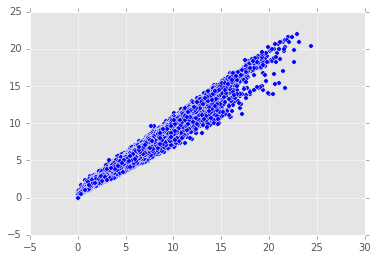

 2624 num_players: 9 17
 2598 num_players: 9 18
 2623 num_players: 10 17
 2635 num_players: 14 18
 2636 num_players: 9 15
 2621 num_players: 10 17
 2618 num_players: 10 16
 2618 num_players: 11 19
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2620 num_players: 10 17
 2595 num_players: 9 15
 2619 num_players: 10 15
 2631 num_players: 8 16
 2633 num_players: 11 15
 2616 num_players: 13 15
 2614 num_players: 11 14
 2614 num_players: 10 17
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2616 num_players: 8 19
 2591 num_players: 10 17
 2615 num_players: 10 16
 2627 num_players: 11 16
 2629 num_players: 11 14
 2612 num_players: 12 17
 2609 num_players: 13 17
 2611 num_players: 13 17
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2613 num_players: 9 15
 2587 num_players: 8 13
 2611 num_players: 11 16
 2622 num_players: 8 15
 2624 num_players: 11 16
 2607 num_players: 9 17
 2605 num_players: 11 13
 2605 num_players: 11 15
game_id:game_id:ga

In [23]:
def inverse_box_cox(y_box, lambda_, min_):
    return np.power((y_box * lambda_) + 1, 1 / lambda_) - 1 + min_
    

predictions = cfr.predict(x_train)
plt.scatter(y_train, predictions)
plt.show()

[Parallel(n_jobs=8)]: Done   1 out of  34 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished


 2502 num_players: 10 18
 2473 num_players: 12 18
 2500 num_players: 9 16
 2500 num_players: 11 13
 2513 num_players: 10 17
 2485 num_players: 8 16
 2490 num_players: 11 20
 2488 num_players: 11 18
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2498 num_players: 10 17
 2468 num_players: 12 16
 2496 num_players: 11 14
 2494 num_players: 12 15
 2508 num_players: 11 17
 2482 num_players: 9 15
 2485 num_players: 12 14
 2483 num_players: 10 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2494 num_players: 10 16
 2463 num_players: 12 16
 2492 num_players: 9 18
 2491 num_players: 9 16
 2503 num_players: 11 14
 2479 num_players: 12 17
 2481 num_players: 10 15
 2480 num_players: 10 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2489 num_players: 9 15
 2459 num_players: 13 17
 2489 num_players: 11 14
 2487 num_players: 10 17
 2498 num_players: 9 16
 2475 num_players: 10 18
 2476 num_players: 9 15
 2476 num_players: 9 15
game_id:game_id:g

/Users/jostheim/Virtualenvs/sidewire/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


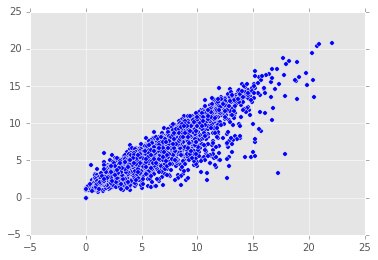

mean_absolute_error 0.663930334455
mean_squared_error 1.30740214467
explained_variance 0.907623765951
median_absolute_error 0.435028384968
r2_score 0.90733340406
 2436 num_players: 10 14
 2408 num_players: 8 15
 2437 num_players: 11 17
 2437 num_players: 9 15
 2448 num_players: 8 17
 2421 num_players: 11 12
 2424 num_players: 9 14
 2423 num_players: 10 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2433 num_players: 9 16
 2406 num_players: 11 17
 2432 num_players: 8 18
 2434 num_players: 7 14
 2446 num_players: 10 15
 2416 num_players: 11 15
 2419 num_players: 10 17
 2418 num_players: 10 14
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2429 num_players: 10 10
 2402 num_players: 8 17
 2430 num_players: 9 19
 2431 num_players: 8 15
 2442 num_players: 11 18
 2412 num_players: 9 15
 2415 num_players: 9 15
 2414 num_players: 9 17
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2425 num_players: 11 16
 2399 num_players: 9 15
 2426 num_

In [24]:
# y_test = inverse_box_cox(y_test, lambda_, min_target)
predictions = cfr.predict(x_test)
x_test['prediction'] = predictions
# predictions = inverse_box_cox(predictions,lambda_, min_target)
plt.scatter(y_test, predictions)
plt.show()
print "mean_absolute_error", mean_absolute_error(y_test, predictions)
print "mean_squared_error", mean_squared_error(y_test, predictions)
print "explained_variance", explained_variance_score(y_test, predictions)
print "median_absolute_error", median_absolute_error(y_test, predictions)
print "r2_score", r2_score(y_test, predictions)

 2305 num_players: 11 16
 2285 num_players: 10 13
 2307 num_players: 8 17
 2310 num_players: 9 16
 2319 num_players: 9 16
 2292 num_players: 10 16
 2299 num_players: 9 14
 2293 num_players: 10 12
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2301 num_players: 9 15
 2281 num_players: 10 16
 2304 num_players: 8 17
 2308 num_players: 10 17
 2315 num_players: 10 15
 2288 num_players: 13 16
 2294 num_players: 11 15
 2290 num_players: 10 13
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2297 num_players: 11 18
 2276 num_players: 10 16
 2300 num_players: 9 19
 2302 num_players: 10 16
 2312 num_players: 11 15
 2283 num_players: 11 14
 2290 num_players: 10 16
 2286 num_players: 9 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2294 num_players: 11 16
 2272 num_players: 11 18
 2296 num_players: 9 16
 2298 num_players: 8 15
 2306 num_players: 10 17
 2280 num_players: 10 14
 2286 num_players: 9 17
 2282 num_players: 9 17
game_id:game_id:game

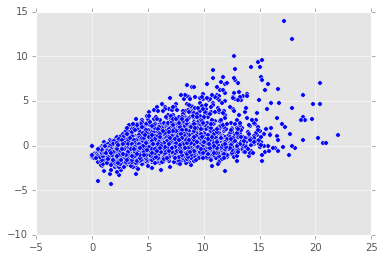

 2238 num_players: 10 15
 2218 num_players: 10 14
 2240 num_players: 10 15
 2250 num_players: 10 18
 2258 num_players: 10 16
 2234 num_players: 12 17
 2231 num_players: 11 13
 2231 num_players: 9 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2234 num_players: 11 14
 2214 num_players: 9 17
 2236 num_players: 10 17
 2246 num_players: 11 17
 2254 num_players: 9 15
 2229 num_players: 8 16
 2228 num_players: 10 15
 2226 num_players: 10 16
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2230 num_players: 11 16
 2210 num_players: 8 13
 2232 num_players: 11 15
 2242 num_players: 11 16
 2251 num_players: 10 15
 2225 num_players: 9 16
 2224 num_players: 11 18
 2221 num_players: 11 15
game_id:game_id:game_id:game_id:game_id:game_id:game_id:game_id: 2225 num_players: 9 17
 2205 num_players: 9 18
 2227 num_players: 9 16
 2239 num_players: 13 16
 2247 num_players: 9 17
 2221 num_players: 9 13
 2219 num_players: 9 16
 2216 num_players: 9 16
game_id:game_id:game_

In [25]:
plt.scatter(y_test, (y_test.values-predictions))
plt.show()